In [23]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from titeseq_functions import *
from multiprocessing import Pool
from functools import partial

In [197]:
data_location = '/scratch/gthurber_root/gthurber0/marcase/titeseq/'
#upload Bloom 2020 data
vc = pd.read_csv(data_location+'variant_counts.csv')
B1351 = pd.read_csv(data_location+'codon_variant_table_B1351.csv')
E484K = pd.read_csv(data_location+'codon_variant_table_E484K.csv')
N501Y = pd.read_csv(data_location+'codon_variant_table_N501Y.csv')
Wuhan_Hu_1 = pd.read_csv(data_location+'codon_variant_table_Wuhan_Hu_1.csv')
all_variants = pd.concat([B1351,E484K,N501Y,Wuhan_Hu_1])

#drop duplicate barcodes
all_variants = all_variants.drop_duplicates(subset='barcode')
all_variants = all_variants.set_index(['barcode','library'])
all_variants = all_variants.set_index(all_variants.index.get_level_values(0) + '_' + all_variants.index.get_level_values(1))

In [198]:
all_variants

,target,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions
AAAAAAAAAATTAAGG_pool1,B1351,3,AGA73CAT GGA172TCT GCA192ACA,R73H G172S A192T,3.0,3.0
AAAAAAAAAGTATTAA_pool1,B1351,1,GTG103AAA,V103K,1.0,1.0
AAAAAAAAATACAATA_pool1,B1351,4,CCT169GGT,P169G,1.0,1.0
AAAAAAAAATGTTAAT_pool1,B1351,2,GAT75CAA,D75Q,1.0,1.0
AAAAAAAAATTACTAA_pool1,B1351,2,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...
TTTTTTAGTACTAGTT_pool2,Wuhan_Hu_1,2,NaN,NaN,0.0,0.0
TTTTTTATGCAAATTA_pool2,Wuhan_Hu_1,3,GAC34AAT,D34N,1.0,1.0
TTTTTTCAACCCGCGT_pool2,Wuhan_Hu_1,1,AGA73AAT,R73N,1.0,1.0
TTTTTTGATTAAGTTA_pool2,Wuhan_Hu_1,1,TGC61GTT,C61V,1.0,1.0


In [4]:
#preprocess data
values='count'
index=['barcode','library','replicate']
columns=['sample']
data = preprocess(vc,values,index,columns)

#calculate frequencies
data = getFrequencies(data)

#filter data
bin_read_fraction=0.5 #quality control parameter
bin_read_threshold=1 #quality control parameter
bimodal_removal=True #quality control parameter
bimodal_removal_threshold=0.8 #quality control parameter
minimum_fraction_removal=0 #quality control parameter
num_bins=4 #from experiment set-up
num_concs=10 #from experiment set-up
filtered_bin_frequencies,masked_concs = filterClones(data,bin_read_fraction,bin_read_threshold,bimodal_removal,bimodal_removal_threshold,
                 minimum_fraction_removal,num_bins,num_concs)

<AxesSubplot:>

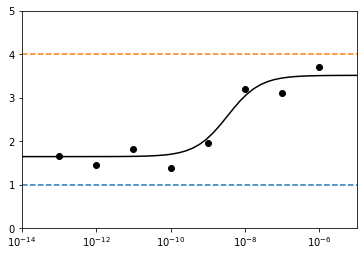

In [5]:
#get data ready for fit
fit_data = getBinScores(data,masked_concs,num_concs=num_concs,num_bins=num_bins)

#plot sample fits
concs = [0,1e-13,1e-12,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6,'sortseq'][::-1]
barcode = ('AAAAAAAAAAATTTAA', 'pool1', 'A')
plotCurveFit(fit_data,barcode,concs)

In [6]:
# fit entire dataset
ncpus = 16
fit_params = multiprocessFit(fit_data,ncpus,concs,n_bins=4,verbose=False)

/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/

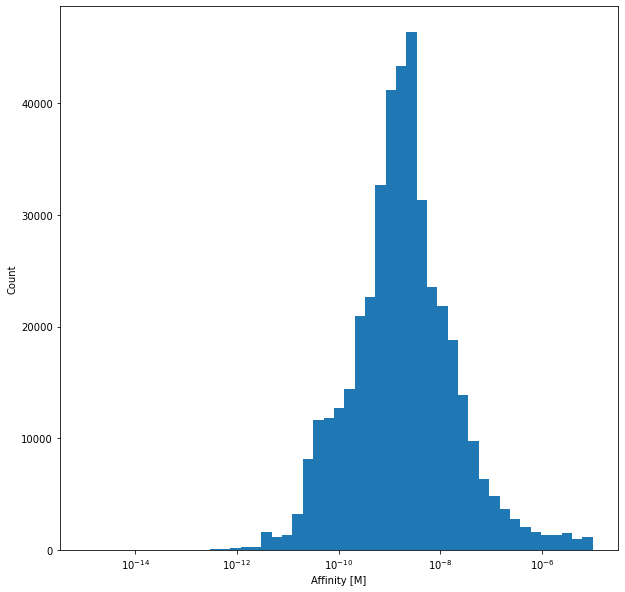

In [18]:
plotDatasetHistogram(fit_params,concs)

In [187]:
#match barcodes with mutations
good_fit_params = fit_params.loc[fit_params['Kd'] > 0.1*np.ma.masked_equal(concs[1:], 0.0, copy=False).min()][['Kd']]

In [189]:
df1 = good_fit_params.reset_index()
chunk_size = 10000
chunks = [x for x in range(0, df1.shape[0], chunk_size)]
good_fit_params = pd.concat([df1.iloc[ chunks[i]:chunks[i + 1] - 1 ].pivot(index=['barcode','library'], columns='replicate', values='Kd') for i in range(0, len(chunks) - 1)])
good_fit_params = good_fit_params.set_index(good_fit_params.index.get_level_values(0) + '_' + good_fit_params.index.get_level_values(1))
good_fit_params

,replicate,A,B
barcode,library,,
AAAAAAAAAAAGGAGA,pool1,NaN,0.0
AAAAAAAAAAATTTAA,pool1,0.0,0.0
AAAAAAAAAACGCGTA,pool1,0.0,0.0
AAAAAAAAAACTAAAA,pool2,0.0,NaN
AAAAAAAAAACTCCAA,pool1,0.0,0.0
...,...,...,...
TTTTGATCCGTGTAAT,pool2,0.0,NaN
TTTTGATCGAGGCTCT,pool1,0.0,0.0
TTTTGATGAACAATTA,pool2,0.0,NaN


In [215]:
merged = pd.concat([all_variants,good_fit_params],join='outer',axis=1)
merged

,target,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions,A,B
AAAAAAAAAATTAAGG_pool1,B1351,3.0,AGA73CAT GGA172TCT GCA192ACA,R73H G172S A192T,3.0,3.0,NaN,NaN
AAAAAAAAAGTATTAA_pool1,B1351,1.0,GTG103AAA,V103K,1.0,1.0,NaN,NaN
AAAAAAAAATACAATA_pool1,B1351,4.0,CCT169GGT,P169G,1.0,1.0,0.0,0.0
AAAAAAAAATGTTAAT_pool1,B1351,2.0,GAT75CAA,D75Q,1.0,1.0,0.0,0.0
AAAAAAAAATTACTAA_pool1,B1351,2.0,NaN,NaN,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...
TTTTGACGAGAAAACC_pool2,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
TTTTGACGTAACGTCC_pool2,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
TTTTGACTATTAATAT_pool2,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
TTTTGATACGGGCAGA_pool2,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


In [226]:
merged.loc[(~(pd.isnull(merged['target']))) & (~(pd.isnull(merged['A'])) | (~pd.isnull(merged['B'])))]

,target,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions,A,B
AAAAAAAAATACAATA_pool1,B1351,4.0,CCT169GGT,P169G,1.0,1.0,0.0,0.0
AAAAAAAAATGTTAAT_pool1,B1351,2.0,GAT75CAA,D75Q,1.0,1.0,0.0,0.0
AAAAAAAACAGGATTG_pool1,B1351,4.0,ATC80ATG,I80M,1.0,1.0,0.0,0.0
AAAAAAAAGTAACGAT_pool1,B1351,6.0,TCT36TAT,S36Y,1.0,1.0,0.0,0.0
AAAAAAAATATGGACA_pool1,B1351,2.0,AAC4TCT,N4S,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
TTTTGACAGTTATAGA_pool2,Wuhan_Hu_1,6.0,GCC67GGT,A67G,1.0,1.0,0.0,NaN
TTTTGACCCAAACGAA_pool2,Wuhan_Hu_1,1.0,ATA104GTT GAA186GGA,I104V E186G,2.0,2.0,0.0,NaN
TTTTGACCCTACATTA_pool2,Wuhan_Hu_1,4.0,AAT13GAA,N13E,1.0,1.0,0.0,NaN
TTTTGACTAATTTTGT_pool2,Wuhan_Hu_1,1.0,AAT58GTT,N58V,1.0,1.0,0.0,NaN


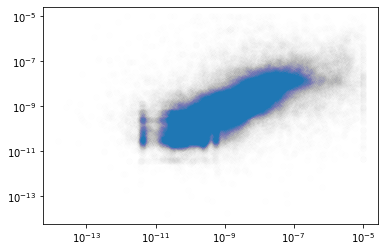

In [175]:
plt.scatter(df1['A'],df1['B'],alpha=0.005)
plt.yscale('log')
plt.xscale('log')